# Controlling for glia activation/inflammation for T cell proximity effect

This notebook contains all experiments relating to computing and characterizing cell proximity effects after controlling for activation signature in microglia and inflammation signature in oligodendrocytes to rule out a competing explanation for the T cell proximity effect (i.e. that rather than exerting a pro-aging effect, they are simply attracted to these pro-aged cells). It uses the spatial aging clocks to compute age acceleration for the analysis.

**Associated manuscript figures/tables:**
- Figures: 4f
- Extended Data Figures: 9q,r,s


**Inputs required:**
- `results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad` - AnnData object for coronal sections data with spatial aging clock predictions (generated from `cv_train_clock.py`)


**Conda environment used**: `requirements/merfish.txt`

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
from scipy.stats import pearsonr, spearmanr, ttest_ind
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("ticks")
from sklearn.neighbors import BallTree

from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests
from decimal import Decimal

from ageaccel_proximity import *

In [2]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

In [3]:
# Distance Cutoff Parameters -- see 5A_regional_proximity_distance_cutoffs.ipynb

cutoff = {'CC/ACO': 24.887910095931538, 'CTX_L1/MEN': 25.91425280674148, 'CTX_L2/3': 24.04649324744985, 'CTX_L4/5/6': 27.243990001598508, 'STR_CP/ACB': 21.6499141249257, 'STR_LS/NDB': 20.355186196238336, 'VEN': 17.863153902391776}

## Proximity effects for activated and non-activated glial cells

In [4]:
new_restricted_celltype_subset = ['Neuron-Excitatory', 'Neuron-MSN','Astrocyte (Normal)','Astrocyte (Activated)','Microglia (Normal)', 'Microglia (Activated)', 'Oligodendrocyte (Normal)', 'Oligodendrocyte (Inflammation)','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

In [5]:
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")
get_age_acceleration (adata)

In [6]:
# from Allen et al., 2022 + Madeddu et al., 2015 + Pandey et al., 2022
astro_activation_genes = ['C4b', 'C3', 'Serpina3n', 'Cxcl10', 'Gfap', 'Vim', 'Il18', 'Hif3a',
                          'Il1a', 'Cd69', 'Cxcl2', 'Ccl3', 'Fpr1', 'Ccl2']
micro_activation_genes = ['B2m', 'Trem2', 'Ccl2', 'Apoe', 'Axl', 'Itgax', 'Cd9', 'C1qa', 'C1qc', 'Lyz2', 'Ctss',
                          'Il6', 'Il1a', 'Il1b', 'Cd69', 'Il12b', 'AW112010', 'Cxcl3', 'Ptgs2', 'Irg1', 'Acpp']
olig_inflammation_genes = ['C4b', 'Il33', 'Il18',
                        'Serpina3n', 'Cdkn1a', 'Tnfrsf12a', 'H2-D1', 'Stat1', 'Ifit1']

astro_activation_genes = np.intersect1d(astro_activation_genes, adata.var_names)
micro_activation_genes = np.intersect1d(micro_activation_genes, adata.var_names)
olig_inflammation_genes = np.intersect1d(olig_inflammation_genes, adata.var_names)

print(astro_activation_genes)
print(micro_activation_genes)
print(olig_inflammation_genes)

['C3' 'C4b' 'Cd69' 'Gfap' 'Il1a']
['Apoe' 'B2m' 'C1qa' 'Cd69' 'Cd9' 'Il1a' 'Il1b' 'Il6' 'Lyz2']
['C4b' 'Cdkn1a' 'H2-D1' 'Ifit1' 'Stat1']


In [7]:
astro_scores = np.array(adata[:,astro_activation_genes].X.sum(axis=1))
micro_scores = np.array(adata[:,micro_activation_genes].X.sum(axis=1))
olig_scores = np.array(adata[:,olig_inflammation_genes].X.sum(axis=1))

In [8]:
adata.obs["Astrocyte_score"] = astro_scores
adata.obs["Microglia_score"] = micro_scores
adata.obs["Oligodendrocyte_score"] = olig_scores

In [9]:
# separate into activated vs non-activated by percentile cutoff

cutoff_percentile = 0.998 # Use 0.8 for Activated Effector and 0.998 for Activated Target (score-matched)

celltype_activated = []

astro_cutoff = np.quantile(astro_scores,cutoff_percentile)
micro_cutoff = np.quantile(micro_scores,cutoff_percentile)
olig_cutoff = np.quantile(olig_scores,cutoff_percentile)

for ci, ct in enumerate(adata.obs['celltype'].values):
    
    if ct == "Astrocyte":
        if astro_scores[ci] > astro_cutoff:
            celltype_activated.append("Astrocyte (Activated)")
        else:
            celltype_activated.append("Astrocyte (Normal)")
            
    elif ct == "Microglia":
        if micro_scores[ci] > micro_cutoff:
            celltype_activated.append("Microglia (Activated)")
        else:
            celltype_activated.append("Microglia (Normal)")
            
    elif ct == "Oligodendrocyte":
        if olig_scores[ci] > olig_cutoff:
            celltype_activated.append("Oligodendrocyte (Inflammation)")
        else:
            celltype_activated.append("Oligodendrocyte (Normal)")
            
    else:
        celltype_activated.append(ct)

In [10]:
adata.obs["celltype"] = celltype_activated

# order cell types
categories_order = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
              'Astrocyte (Normal)', 'Astrocyte (Activated)', 'Microglia (Normal)', 'Microglia (Activated)', 'Oligodendrocyte (Normal)', 'Oligodendrocyte (Inflammation)', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']
adata.obs['celltype'] = adata.obs['celltype'].astype('category').cat.reorder_categories(categories_order)

In [11]:
# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

In [12]:
# recompute with celltype_activated


cutoff_multiplier = 1

celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
              'Astrocyte (Normal)', 'Astrocyte (Activated)', 'Microglia (Normal)', 'Microglia (Activated)', 'Oligodendrocyte (Normal)', 'Oligodendrocyte (Inflammation)', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

#celltypes = ['T cell']

scores_all = []
celltypes_for_scores = []
proximity_for_scores = []

###########################
comb_df = pd.DataFrame([])

for celltype in celltypes:
    
    for ct in pd.unique(adata.obs.celltype).sort_values():
        
        sub_adata = adata[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)
        
        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata, min_pairs=1)
        
        comb_df = pd.concat((comb_df, df))
        
        ### Append scores
        if (celltype=="T cell") and (ct in ['Astrocyte (Activated)', 'Microglia (Activated)', 'Oligodendrocyte (Inflammation)']):
            scores_all = np.concatenate((scores_all, sub_adata.obs[f"{ct.split(' (')[0]}_score"]))
            celltypes_for_scores = np.concatenate((celltypes_for_scores, [ct]*sub_adata.shape[0]))
            proximity_for_scores = np.concatenate((proximity_for_scores, near_ages))

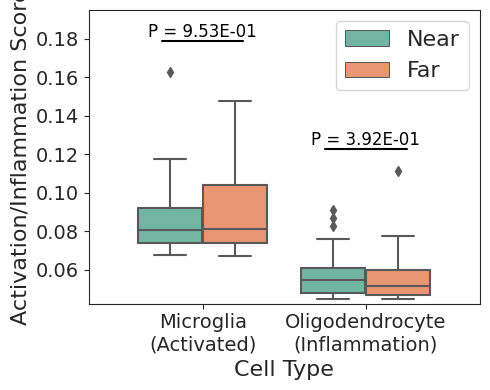

In [13]:
# check activation/inflammation scores
score_df = pd.DataFrame(np.vstack((scores_all,proximity_for_scores,celltypes_for_scores)).T, columns=["score","Proximity to T cell","celltype"])
score_df = score_df[score_df["Proximity to T cell"].isin(["Near","Far"])]
score_df = score_df[score_df["celltype"].isin(['Microglia (Activated)', 'Oligodendrocyte (Inflammation)'])]
score_df["celltype"] = [x.split(" (")[0]+"\n("+x.split(" (")[1] for x in score_df["celltype"]]
score_df["score"] = score_df["score"].astype('float')

#----------------
fig, ax = plt.subplots(figsize=(5,4))

sns.boxplot(score_df, x="celltype", y="score", hue="Proximity to T cell", palette='Set2')


# statistical annotation
x_coords = [0, 1, 2]
y_coords = []
cols = ['k']*len(x_coords)
h = 0
w = 0.25
pval_labels = []
for ct in np.unique(score_df["celltype"]):
    t,p = mannwhitneyu(score_df[(score_df["celltype"]==ct)&(score_df["Proximity to T cell"]=="Near")]["score"], score_df[(score_df["celltype"]==ct)&(score_df["Proximity to T cell"]=="Far")]["score"])
    y_coords.append(1.1*np.max(score_df[(score_df["celltype"]==ct)]["score"]))
    pval_labels.append(p)
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=12)
plt.ylim([np.min(score_df["score"])-0.05*np.abs(np.min(score_df["score"])),
            np.max(score_df["score"])*1.2])


plt.ylabel(f"Activation/Inflammation Score", fontsize=16)
plt.xlabel("Cell Type", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(f"plots/proximity/ActivationScoreBoxPlot_GlialActivationTcellonly_spatialsmooth_regionmatchedfarthest_cutoff{int((1-cutoff_percentile)*1000)}.pdf",
           bbox_inches='tight')
plt.show()

### Could not get a cutoff to match activation scores between Near and Far activated astrocytes (P-value > 0.05) so dropping from control setup

/local/scratch/edsun/slrmtmp.42224525/ipykernel_93268/534609584.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = sub_cond_df.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


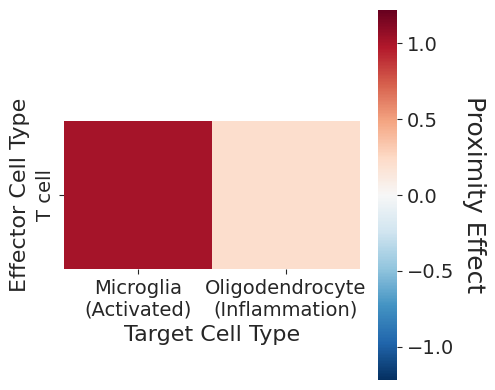

In [14]:
effector_cells = ["T cell"]

receiver_cells = ["Oligodendrocyte (Inflammation)",
                  "Microglia (Activated)"]

###########################################################
sub_cond_df = comb_df[comb_df['Near Cell'].isin(effector_cells)]
sub_cond_df = sub_cond_df[sub_cond_df['AgeAccel Cell'].isin(receiver_cells)]
sub_cond_df["Near Cell"] = sub_cond_df["Near Cell"].astype('category').cat.reorder_categories([x for x in effector_cells if x in sub_cond_df['Near Cell'].values])
sub_cond_df["AgeAccel Cell"] = sub_cond_df["AgeAccel Cell"].astype('category').cat.reorder_categories([x for x in receiver_cells if x in sub_cond_df['AgeAccel Cell'].values])

sub_cond_df["AgeAccel Cell"] = [x.split(" (")[0]+"\n("+x.split(" (")[1] for x in sub_cond_df["AgeAccel Cell"]]


pivot_df = sub_cond_df.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")


fig, ax = plt.subplots(figsize=(5,4))
# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 16, "va": "center_baseline", "color": "0.5"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap="RdBu_r",
            vmin=-np.max(np.abs(sub_cond_df["Aging Effect"]))*1.2,
            vmax=np.max(np.abs(sub_cond_df["Aging Effect"]))*1.2)

ax.collections[1].colorbar.set_label('Proximity Effect',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Target Cell Type", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f"plots/proximity/celltype_proximity_age_accel_ttest_heatmap_GlialActivationTcellonly_spatialsmooth_regionmatchedfarthest_cohensd_cutoff{int((1-cutoff_percentile)*1000)}.pdf",
           bbox_inches='tight')
plt.show()

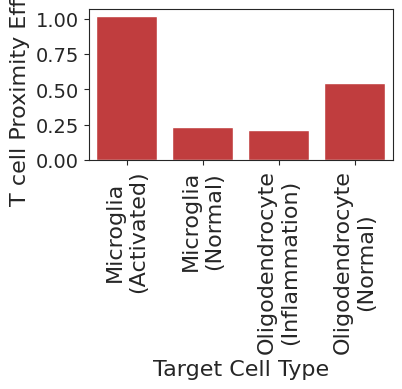

In [28]:
celltypes = []
average_effects = []
colors = []


effector_cells = ["T cell"]

target_cells = ["Oligodendrocyte (Normal)", "Oligodendrocyte (Inflammation)",
                  "Microglia (Normal)", "Microglia (Activated)"]

sub_cond_df = comb_df[comb_df['Near Cell'].isin(effector_cells)].copy()
sub_cond_df = sub_cond_df[sub_cond_df['AgeAccel Cell'].isin(target_cells)].copy()
sub_cond_df["AgeAccel Cell"] = [x.split(" (")[0]+"\n("+x.split(" (")[1] for x in sub_cond_df["AgeAccel Cell"]]


for ct in np.unique(sub_cond_df["AgeAccel Cell"]):
    average_effect = np.nanmean(sub_cond_df[sub_cond_df["AgeAccel Cell"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)

# Make Bar Plot
palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

plt.figure(figsize=(4,4))

g = sns.barplot(
    x=celltypes,
    y=average_effects,
    hue=colors,
    palette=palette,
)
g.legend_.remove()

plt.ylabel("T cell Proximity Effect", fontsize=16)
plt.xlabel("Target Cell Type", fontsize=16)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f"plots/proximity/celltype_proximity_age_accel_verbar_cohensd_GlialActivationTcellonly_RESTRICTED_cutoff{int((1-cutoff_percentile)*1000)}.pdf",
           bbox_inches='tight')
plt.show()

### Statistics for activated microglia / inflammed oligodendrocyte proximities

In [13]:
# add proximity info to adata

cutoff_multiplier = 1

celltypes = ['T cell', 'NSC', 'Endothelial']

###########################
keep_idxs = []

for celltype in celltypes: # effector cells
    
    prox_labels = np.array(["Other"]*adata.shape[0])
    
    for ct in new_restricted_celltype_subset: # affected cells
        
        sub_adata = adata[adata.obs["celltype"]==ct].copy()
        orig_idxs = np.arange(adata.shape[0])[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier)
        
        # update proximity labels
        prox_labels[orig_idxs] = near_ages 
        
        # keep far and near cells
        near_or_far_idxs = np.arange(sub_adata.shape[0])[(near_ages=="Near")|(near_ages=="Far")]
        keep_idxs = np.concatenate((keep_idxs,orig_idxs[near_or_far_idxs]))
    
    # annote adata with proximity (near/far/other)
    adata.obs[f"proximity to {celltype}"] = prox_labels

In [14]:
# subset into inflammed oligodendrocytes and activated microglia

adata_olig = adata[adata.obs.celltype=='Oligodendrocyte (Inflammation)']
adata_micro = adata[adata.obs.celltype=='Microglia (Activated)']

num_cts = {} # to count num of cell types
for ct in np.unique(adata.obs.celltype):
    num_cts[ct] = np.sum(adata.obs.celltype==ct)

In [26]:
# fraction of activated cells near vs far from T cells // normalized by num T cells

print("Fraction Activated Microglia near T cell:")
print(round(np.sum(adata_micro.obs['proximity to T cell']=='Near')/num_cts['T cell'],4))

print("Fraction Inflammed Oligodendrocyte near T cell:")
print(round(np.sum(adata_olig.obs['proximity to T cell']=='Near')/num_cts['T cell'],4))

print("")

print("Fraction Activated Microglia near NSC:")
print(round(np.sum(adata_micro.obs['proximity to NSC']=='Near')/num_cts['NSC'],4))

print("Fraction Inflammed Oligodendrocyte near NSC:")
print(round(np.sum(adata_olig.obs['proximity to NSC']=='Near')/num_cts['NSC'],4))


print("")

print("Fraction Activated Microglia near Endothelial:")
print(round(np.sum(adata_micro.obs['proximity to Endothelial']=='Near')/num_cts['Endothelial'],4))

print("Fraction Inflammed Oligodendrocyte near Endothelial:")
print(round(np.sum(adata_olig.obs['proximity to Endothelial']=='Near')/num_cts['Endothelial'],4))

Fraction Activated Microglia near T cell:
0.0154
Fraction Inflammed Oligodendrocyte near T cell:
0.0614

Fraction Activated Microglia near NSC:
0.0039
Fraction Inflammed Oligodendrocyte near NSC:
0.0046

Fraction Activated Microglia near Endothelial:
0.0007
Fraction Inflammed Oligodendrocyte near Endothelial:
0.0026


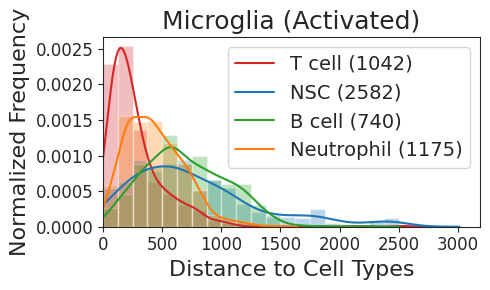

In [21]:
# Microglia
colors = ["tab:red", "tab:blue", "tab:green", "tab:orange"]

plt.figure(figsize=(5,3))
for i, ct in enumerate(["T cell", "NSC", "B cell", "Neutrophil"]):
    plt.hist(adata_micro.obs[f'{ct}_nearest_distance'], color=colors[i], alpha=0.3, bins=20, range=(0,2500), density=True)
    sns.kdeplot(adata_micro.obs[f'{ct}_nearest_distance'], label=f"{ct} ({num_cts[ct]})", color=colors[i])
plt.xlim(0,None)
plt.title("Microglia (Activated)", fontsize=18)
plt.ylabel("Normalized Frequency", fontsize=16)
plt.xlabel("Distance to Cell Types", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14, loc='upper right')
plt.tight_layout()
plt.savefig(f"plots/proximity/distance_density_microglia_activation_RESTRICTED_cutoff{int((1-cutoff_percentile)*1000)}.pdf",
           bbox_inches='tight')
plt.show()

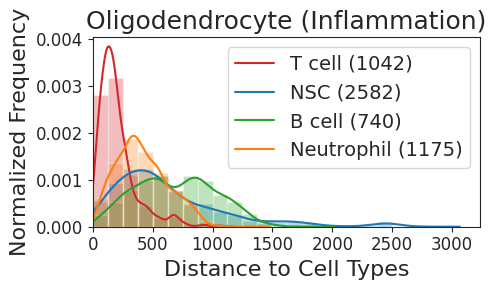

In [22]:
# Oligodendrocyte
colors = ["tab:red", "tab:blue", "tab:green", "tab:orange"]

plt.figure(figsize=(5,3))
for i, ct in enumerate(["T cell", "NSC", "B cell", "Neutrophil"]):
    plt.hist(adata_olig.obs[f'{ct}_nearest_distance'], color=colors[i], alpha=0.3, bins=20, range=(0,2500), density=True)
    sns.kdeplot(adata_olig.obs[f'{ct}_nearest_distance'], label=f"{ct} ({num_cts[ct]})", color=colors[i])
plt.xlim(0,None)
plt.title("Oligodendrocyte (Inflammation)", fontsize=18)
plt.ylabel("Normalized Frequency", fontsize=16)
plt.xlabel("Distance to Cell Types", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14, loc='upper right')
plt.tight_layout()
plt.savefig(f"plots/proximity/distance_density_oligodendrocyte_activation_RESTRICTED_cutoff{int((1-cutoff_percentile)*1000)}.pdf",
           bbox_inches='tight')
plt.show()